# Mastering Scene Understanding:  Scene Graphs to the Rescue

## Generation of complex scene images
-----

## Diffusion-Based Scene Graph to Image Generation with Masked Contrastive Pre-Training
Based on the [Official Implementation](https://github.com/YangLing0818/SGDiff/tree/main) for [Diffusion-Based Scene Graph to Image Generation with Masked Contrastive Pre-Training](https://arxiv.org/abs/2211.11138).

### Environment and dataset setup
---

Start by setting the environment with miromamba:

```
micromamba create -f sgdiff.yaml
micromamba activate sgdiff
```

#### Data and Model Preparation

The instructions of data pre-processing can be [found here](https://github.com/YangLing0818/SGDiff/blob/main/DATA.md) (note that this notebook only covers the Visual Genome dataset, so you can skip the MS-COCO instructions).

The authors' masked contrastive pre-trained models of SG-image pairs for COCO and VG datasets are provided in [here](https://www.dropbox.com/scl/fo/lccvtxuwxxblo3atnxlmg/h?rlkey=duy7dcwmy3a64auqoqiw8dv2e&dl=0), please download them and put them in the `pretrained` directory.

And the pretrained VQVAE for embedding image to latent can be obtained from https://ommer-lab.com/files/latent-diffusion/vq-f8.zip. After decompressing the model rename `model.ckpt` to `vq-f8-model.ckpt` and place it together with the other models inside the `pretrained` directory.

#### Pre-trained Diffusion Model

Trained wieghts for the diffusion model can be found here: [sgdiff_epoch_335.ckpt](https://flinders-my.sharepoint.com/:u:/g/personal/neau0001_flinders_edu_au/EQTJcd62dU1HirhpNtqzDIABsrZJqphm1nJV3dDggSSVxA?e=PHPjRk). Please download and move/rename the file to `./pretrained_model.ckpt`

This checkpoint was trained for 335 epochs and scores FID=23.54 and IS=18.02 on the test set of Visual Genome.

### Initial Code Setup
----
We start with basic imports

In [1]:
import json
import os

import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from einops import rearrange

from ldm.models.diffusion.ddim import DDIMSampler
from testset_ddim_sampler import (get_model, build_loaders, draw_scene_graph, 
                                  load_model_from_config, VgSceneGraphDataset, Resize, vg_collate_fn)

/home/leo.ribeiro/micromamba/envs/sgdiff/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We load up our model and the diffusion sampler

In [2]:
model = get_model()
sampler = DDIMSampler(model)

Loading model from ./pretrained_model.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 395.77 M params.
Keeping EMAs of 630.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Restored from pretrained/vq-f8-model.ckpt with 0 missing and 49 unexpected keys
Restored from pretrained/sip_vg.pt with 0 missing and 308 unexpected keys


Open our vocabulary file (this json describes the objects and predicates available to our scene graphs)

In [3]:
vocab_file = './datasets/vg/vocab.json'
with open(vocab_file, 'r') as f:
    vocab = json.load(f)

Create our dataset object. It is resposible for reading images and their scene graphs.

We are using the **Visual Genome** test set here.

In [4]:
dset_kwargs = {
        'vocab_path': './datasets/vg/vocab.json',
        'h5_path': './datasets/vg/test.h5',
        'image_dir': './datasets/vg/images',
        'image_size': (256, 256),
        'max_samples': None,
        'max_objects': 30,
        'use_orphaned_objects': True,
        'include_relationships': True,
    }
dset = VgSceneGraphDataset(**dset_kwargs)

We take a sample from the Visual Genome dataset. Selected input is "batched" and transfered to the GPU memory

In [5]:
sample = dset[3]
batched_sample = vg_collate_fn([sample])
og_img = Image.fromarray((255. * rearrange(batched_sample[0][0], 'c h w -> h w c')).numpy().astype(np.uint8))
imgs, objs, boxes, triples, obj_to_img, triple_to_img = [x.cuda() for x in batched_sample]

Check the Scene Graph for this scene

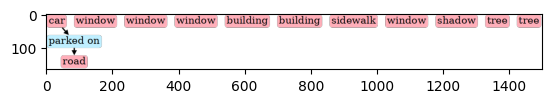

In [6]:
draw_scene_graph(objs=objs, triples=triples, vocab=vocab, output_filename='/tmp/sg.png')
plt.imshow(Image.open('/tmp/sg.png'))

Extract embedding that represents visual characteristics of objects and the scene graph

In [7]:
graph_info = [imgs, objs, None, triples, obj_to_img, triple_to_img]
cond = model.get_learned_conditioning(graph_info)

Finally we can run our difusion model conditioned on this embedding. We plot the original image on the side for reference.

Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:15<00:00, 12.92it/s]


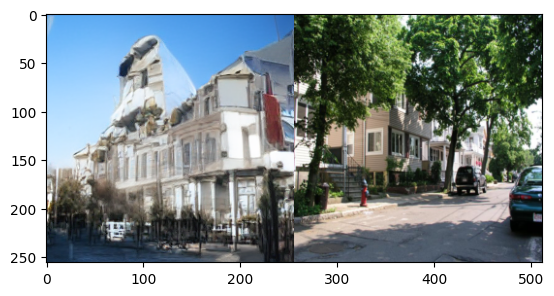

In [8]:
samples_ddim, _ = sampler.sample(S=200,
                                 conditioning=cond,
                                 batch_size=1,
                                 shape=[4, 32, 32],
                                 verbose=False,
                                 eta=1.0)
x_samples_ddim = model.decode_first_stage(samples_ddim)
x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
x_samples_ddim = x_samples_ddim.squeeze(0)
x_samples_ddim = 255. * rearrange(x_samples_ddim, 'c h w -> h w c').cpu().numpy()
results = Image.fromarray(x_samples_ddim.astype(np.uint8))
plt.imshow(np.concatenate([results, og_img], axis=1))
# plt.imshow()